In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import tensorflow as tf
import keras 
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras import backend as K
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from sklearn.model_selection import StratifiedKFold
import cv2
from skimage import io

from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,roc_curve,auc

from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import random
import pandas as pd
from keras import losses
from skimage.io import imsave, imread
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"

/home/dgxadmin/anaconda3/envs/zzaem2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dgxadmin/anaconda3/envs/zzaem2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dgxadmin/anaconda3/envs/zzaem2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dgxadmin/anaconda3/envs/zzaem2/lib

In [2]:
pwd

'/home/dgxadmin/gcubme_ai/Workspace/JW_Seo/DVT_detection/Radiomics/code/deep_learning'

In [2]:
def base_block(inputs, filters = 4, scale = 2):
    
#     x = Conv2D(filters, 3, strides= 1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation(activation='relu')(x)
   
    x = Conv2D(filters, 3, strides=1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    base_out = Activation(activation='relu')(x)

    
    return base_out

def bottleneck(inputs, filters):

    x = Conv2D(filters, 1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters, 3, activation=None, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters, 1, activation=None, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    

    return x

def residual_block(inputs, filters):
    
    shortcut = inputs
    print('input')
    print('shortcut:',shortcut.shape)
    print('x:',inputs.shape)
    
    x = Conv2D(filters, kernel_size=3, strides=1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    
    x = bottleneck(x, filters)
    
    shortcut = Conv2D(filters, kernel_size=1, strides=1, activation=None, padding='same', kernel_initializer='he_normal')(shortcut)
    shortcut = BatchNormalization()(shortcut)
#     shrotcut = Activation(activation='relu')(shrotcut)
    print('before add')
    print('shortcut:',shortcut.shape)
    print('x:',x.shape)
    x = add([x, shortcut])
    
    res_out = Activation(activation='relu')(x)
    
    return res_out

def res_block(inputs, filters):
    
    shortcut = inputs
    
    shrotcut = Conv2D(filters, 1, activation=None, padding='same', kernel_initializer='he_normal')(shortcut)
    shrotcut = BatchNormalization()(shrotcut)
    shrotcut = Activation(activation='relu')(shrotcut)
    
    x = Conv2D(filters, 1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters, 3, activation=None, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters, 1, activation=None, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = add([x, shortcut])
    
    res_out = Activation(activation='relu')(x)
    
    return res_out
def base_classification_jw(inputs, filters = 4, scale = 2):
    
    layer=2
    for br in range(layer):
        
        if br == 0:
            print(br)
            conv= base_block(inputs)
            
            conv = MaxPooling2D(pool_size=(3, 3), strides = 2)(conv)
            print(conv.shape)
            
        else:
            print(br)
            print(conv.shape, scale, br, filters)
            num = (scale**br) *  filters
#             conv= residual_block(conv, filters= num)
            conv= base_block(conv, filters= num)
            print(conv.shape)
            print(num)
    
            conv= MaxPooling2D(pool_size=(2, 2), strides = 2)(conv)
            print(conv.shape)
    for ar in range(layer):
        print(num)
        num = int(num/scale)
        conv = base_block(conv, filters = num)
        print(num)    
        
            
    out= Flatten()(conv)
  
    out = Dense(1, activation="sigmoid")(out)
    
    
    
    model = Model(inputs=inputs, outputs=out)
    
    return model           

In [3]:
from keras.models import Sequential

input_img = Input(shape=(32,32,1))
model = base_classification_jw(input_img, filters = 4, scale = 2)
model.summary()

0

(?, 15, 15, 4)
1
(?, 15, 15, 4) 2 1 4
(?, 15, 15, 8)
8
(?, 7, 7, 8)
8
4
4
2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         40        
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 4)         16        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 8)         296       
______________________________________________

In [4]:
def calculate_performance(pred, test_y):
    tp=0
    fp=0
    tn=0
    fn=0
    alpha = 0.0001
    for cm in range(len(test_y)):
        if list(test_y)[cm]==0:
            if pred[cm]<0.5:
                tn+=1
            else:
                fn+=1
        else:
            if pred[cm]<0.5:
                fp+=1
            else:
                tp+=1
    print(tp, fp, tn, fn)
    sensitivity= (tp+alpha)/(tp+fn+alpha)
    specificity= (tn+alpha)/(tn+fp+alpha) 
    acc = (tp+tn+alpha)/(tp+fp+tn+fn+alpha)
    prec = tp+alpha/(tp+fp+alpha)

    return tp, fp, tn, fn, sensitivity, specificity, acc, prec

In [6]:
k=5
abList = sorted(glob.glob('../../data/abnormal/*'))
nList = sorted(glob.glob('../../data/normal/*'))
split = round(len(abList)/k)
for s in range(k):
    print(s)
    a=0
    for sp in range(split):
        check = sorted(glob.glob(abList[s*sp+sp]+'/*.png'))
        a+=len(check)
    print(a)
               

0
1447
1
1597
2
1714
3
2406
4
1448


(1624, 32, 32, 1) (1624,)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: 1299 TEST: 325
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
163 1 0 973
TRAIN: 1299 TEST: 325
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
0 164 163 1135
TRAIN: 1299 TEST: 325
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
0 327 326 1298
TRAIN: 1299 TEST: 325
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
0 489 488 1461
TRAIN: 1300 TEST: 324
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
0 650 1461 1623


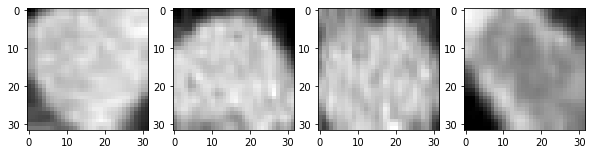

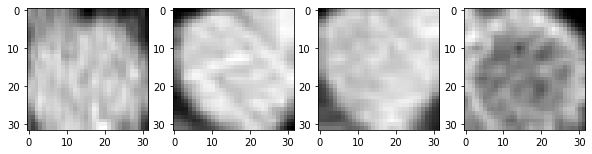

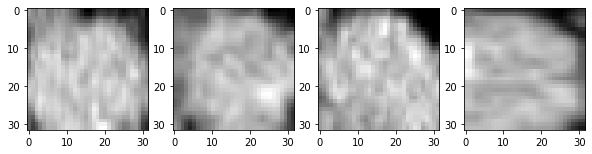

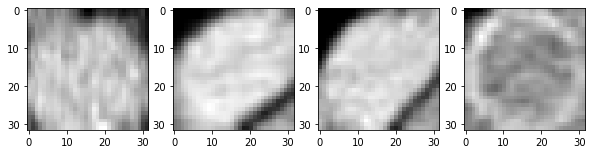

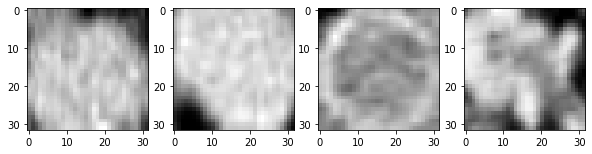

In [5]:
k=5

abnormal = np.load('../../data/npy/abnormal_16to32.npy')
normal = np.load('../../data/npy/normal_16to32.npy')
data_x = np.concatenate((normal, abnormal))
data_y = np.ndarray((len(data_x)),dtype=np.float32)
for n in range(len(data_x)):
    if n < len(normal):
        data_y[n] = 0
    else:
        data_y[n] = 1
print(data_x.shape, data_y.shape)        
# train_x,train_x,test_y,test_y = train_test_split(data_x,data_y, stratify = data_y, train_size=1300, random_state = 25)

skf = StratifiedKFold(n_splits=k)
skf.get_n_splits(data_x,data_y)
print(skf)
i=0
for train_index, test_index in skf.split(data_x,data_y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    indexs = np.concatenate((train_index, test_index), axis= 0)
    train_index = indexs[:1300]
    test_index = indexs[1300:]
    print("RETRAIN:", len(train_index), "RETEST:", len(test_index))
    train_x, test_x = data_x[train_index], data_x[test_index]
    train_y, test_y = data_y[train_index], data_y[test_index]
    print(train_x.shape, test_x.shape)
    plt.figure(figsize=(10,10))
    print(train_index[0],test_index[0],train_index[len(train_index)-1],test_index[len(test_index)-1])
    plt.subplot(1,4,1)
    plt.imshow(train_x[0], cmap='gray')
    plt.subplot(1,4,2)
    plt.imshow(test_x[0], cmap='gray')
    plt.subplot(1,4,3)
    plt.imshow(train_x[len(train_x)-1], cmap='gray')
    plt.subplot(1,4,4)
    plt.imshow(test_x[len(test_x)-1], cmap='gray')
 

In [29]:
i=0
performances = np.ndarray((k,4), dtype=np.float32)

for train_index, test_index in skf.split(data_x,data_y):
    print(i)
    i+=1
    

0
1
2
3
4


In [6]:
savepath='./210512_basic_freeze'
os.makedirs(savepath+'/npy', exist_ok=True)
os.makedirs(savepath+'/result', exist_ok=True)
os.makedirs(savepath+'/model', exist_ok=True)
i=0
performances = np.ndarray((k,4), dtype=np.float32)

for train_index, test_index in skf.split(data_x,data_y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
#     indexs = np.concatenate((train_index, test_index), axis= 0)
#     train_index = indexs[:1300]
#     test_index = indexs[1300:]
#     print("RETRAIN:", len(train_index), "RETEST:", len(test_index))
    dtrain_x, test_x = data_x[train_index], data_x[test_index]
    dtrain_y, test_y = data_y[train_index], data_y[test_index]
    
    np.save(savepath+'/npy/test_x_fold{}.npy'.format(str(i)), test_x)
    np.save(savepath+'/npy/test_y_fold{}.npy'.format(str(i)), test_y)
    np.save(savepath+'/npy/train_x_fold{}.npy'.format(str(i)), train_x)
    np.save(savepath+'/npy/train_y_fold{}.npy'.format(str(i)), train_y)
    
    train_x,val_x,train_y,val_y = train_test_split(dtrain_x,dtrain_y, stratify = dtrain_y, train_size=1040)

    input_img = Input(shape=(32,32,1))
    model = base_classification_jw(input_img, filters = 4, scale = 2)

    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath=savepath+'/model/base3_filter4_fold{}_0512.h5'.format(str(i)), verbose=1, save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=10, min_lr=0, min_delta=0.001, verbose=1)
    earlystopper = EarlyStopping(patience=30, verbose=1, monitor='loss')
    callbacks_list = [reduce_lr, checkpointer, earlystopper]
    
    results = model.fit(train_x, train_y, batch_size=128, epochs=500, verbose=1, validation_data=(val_x, val_y), shuffle=False, callbacks=callbacks_list)
    i+=1

TRAIN: 1299 TEST: 325
0
(?, 15, 15, 4)
1
(?, 15, 15, 4) 2 1 4
(?, 15, 15, 8)
8
(?, 7, 7, 8)
8
4
4
2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1040 samples, validate on 259 samples
Epoch 1/500
1040/1040 [==============================] - 4s 4ms/step - loss: 0.9438 - accuracy: 0.5019 - val_loss: 6.1023 - val_accuracy: 0.5019

Epoch 00001: val_loss improved from inf to 6.10230, saving model to ./210512_basic_freeze/model/base3_filter4_fold0_0512.h5
Epoch 2/500
1040/1040 [==============================] - 0s 175us/step - loss: 0.6765 - accuracy: 0.5615 - val_loss: 2.1936 - val_accuracy: 0.5019

Epoch 00002: val_loss improved from 6.10230 to 2.19356, saving model to ./210512_basic_freeze/model/base3_filter4_fold0_0512.h5
Epoch 3/500
1040/1040 [==============================] - 0s 118us/step - loss: 0.5068 - accuracy: 0.8010 - val_loss: 0.7378 - val_accuracy: 0.5212

Epoch 00003: val_loss improved from 2.19356 to 0.73776, saving m

In [7]:
# check model and save result
i=0
performances = np.ndarray((k,4), dtype=np.float32)
for i in range(k):
    print(i)
    test_model = load_model(savepath+'/model/base3_filter4_fold{}_0512.h5'.format(str(i)))
    test_x= np.load(savepath+'/npy/test_x_fold{}.npy'.format(str(i)))
    test_y= np.load(savepath+'/npy/test_y_fold{}.npy'.format(str(i)))
    test_result= test_model.predict(test_x, batch_size=128, verbose=1)
    np.save(savepath+'/npy/test_result_fold{}.npy'.format(str(i)), test_result)
    fpr_res,tpr_res,_=roc_curve(test_y,test_result)
    auc_res=auc(fpr_res, tpr_res)
    #     print("loss: %.2f, 정확도: %.3f  " %(score[0], score[1]))
    res_tp, res_fp, res_tn, res_fn, res_sensitivity, res_specificity, acc, prec= calculate_performance(test_result, test_y)
    
    performanceList = [auc_res, res_sensitivity, res_specificity, acc]
    for a in range(4):
        performances[i][a] = performanceList[a]
    
#     interp_tpr = np.interp(mean_fpr, _, _)
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)
#     np.save('./210512/npy/performanceList_fold{}.npy'.format(str(i)), performances)
    print('###########RESULT########')
    print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}, PREC:{}'.format(round(auc_res,3),round(res_sensitivity,3),round(res_specificity,3),round(acc,3),round(prec,3)))
    print('TP:{}, FP:{}. TN:{}, FN:{}'.format(res_tp, res_fp, res_tn, res_fn))
    print('#########################')
    i=+1
np.save(savepath+'/npy/performanceList.npy', performances)
all_perform = pd.DataFrame(performances)
all_perform.to_csv(savepath+'/result/all_perform.csv')

0
325/325 [==============================] - 1s 2ms/step
135 27 158 5
###########RESULT########
AUC:0.979, SEN:0.964, SPEC:0.854, ACC:0.902, PREC:135.0
TP:135, FP:27. TN:158, FN:5
#########################
1
325/325 [==============================] - 0s 1ms/step
152 10 163 0
###########RESULT########
AUC:0.997, SEN:1.0, SPEC:0.942, ACC:0.969, PREC:152.0
TP:152, FP:10. TN:163, FN:0
#########################
2
325/325 [==============================] - 1s 2ms/step
152 11 147 15
###########RESULT########
AUC:0.962, SEN:0.91, SPEC:0.93, ACC:0.92, PREC:152.0
TP:152, FP:11. TN:147, FN:15
#########################
3
325/325 [==============================] - 1s 3ms/step
159 4 161 1
###########RESULT########
AUC:1.0, SEN:0.994, SPEC:0.976, ACC:0.985, PREC:159.0
TP:159, FP:4. TN:161, FN:1
#########################
4
324/324 [==============================] - 1s 3ms/step
160 2 138 24
###########RESULT########
AUC:0.994, SEN:0.87, SPEC:0.986, ACC:0.92, PREC:160.0
TP:160, FP:2. TN:138, FN:24
#####

0
135 27 158 5
###########RESULT########
AUC:0.979, SEN:0.964, SPEC:0.854, ACC:0.902, PREC:135.0
TP:135, FP:27. TN:158, FN:5
#########################
1
152 10 163 0
###########RESULT########
AUC:0.997, SEN:1.0, SPEC:0.942, ACC:0.969, PREC:152.0
TP:152, FP:10. TN:163, FN:0
#########################
2
152 11 147 15
###########RESULT########
AUC:0.962, SEN:0.91, SPEC:0.93, ACC:0.92, PREC:152.0
TP:152, FP:11. TN:147, FN:15
#########################
3
159 4 161 1
###########RESULT########
AUC:1.0, SEN:0.994, SPEC:0.976, ACC:0.985, PREC:159.0
TP:159, FP:4. TN:161, FN:1
#########################
4
160 2 138 24
###########RESULT########
AUC:0.994, SEN:0.87, SPEC:0.986, ACC:0.92, PREC:160.0
TP:160, FP:2. TN:138, FN:24
#########################
[0.9938271604938271, 0.8695652882797347, 0.98571429591836, 0.9197531111873114]


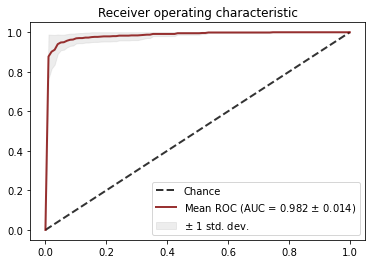

<Figure size 720x720 with 0 Axes>

In [8]:
#plot
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# performances = np.ndarray((k,4), dtype=np.float32)
for i in range(k):
    print(i)
#     test_model = load_model(savepath+'/model/residual3_filter4_fold{}_0512.h5'.format(str(i)))
    test_x= np.load(savepath+'/npy/test_x_fold{}.npy'.format(str(i)))
    test_y= np.load(savepath+'/npy/test_y_fold{}.npy'.format(str(i)))
    test_result= np.load(savepath+'/npy/test_result_fold{}.npy'.format(str(i)))
#     np.save(savepath+'/npy/test_result_fold{}.npy'.format(str(i)), test_result)
    fpr_res,tpr_res,_=roc_curve(test_y,test_result)
    auc_res=auc(fpr_res, tpr_res)
    #     print("loss: %.2f, 정확도: %.3f  " %(score[0], score[1]))
    res_tp, res_fp, res_tn, res_fn, res_sensitivity, res_specificity, acc, prec= calculate_performance(test_result, test_y)
    
    performanceList = [auc_res, res_sensitivity, res_specificity, acc]
    for a in range(4):
        performances[i][a] = performanceList[a]
    
#     interp_tpr = np.interp(mean_fpr, _, _)
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)
#     np.save('./210512/npy/performanceList_fold{}.npy'.format(str(i)), performances)
    print('###########RESULT########')
    print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}, PREC:{}'.format(round(auc_res,3),round(res_sensitivity,3),round(res_specificity,3),round(acc,3),round(prec,3)))
    print('TP:{}, FP:{}. TN:{}, FN:{}'.format(res_tp, res_fp, res_tn, res_fn))
    print('#########################')
#     i=+1

    interp_tpr = np.interp(mean_fpr, fpr_res,tpr_res)
    interp_tpr[0] = 0.0

    tprs.append(interp_tpr)
    aucs.append(auc_res)
# print(XGB_result)
print(performanceList)
fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,10))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
        label='Chance', alpha=.8)

mean_tpr_xgb = np.mean(tprs, axis=0)
mean_tpr_xgb[-1] = 1.0
mean_auc_xgb = auc(mean_fpr, mean_tpr_xgb)
std_auc_xgb = np.std(aucs)
ax.plot(mean_fpr, mean_tpr_xgb, color='maroon',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_xgb, std_auc_xgb),
        lw=2, alpha=.8)
ax.plot(mean_fpr, mean_tpr_xgb, color='maroon',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_xgb, std_auc_xgb),
        lw=2, alpha=.8)

std_tpr_xgb = np.std(tprs, axis=0)
tprs_upper_xgb = np.minimum(mean_tpr_xgb + std_tpr_xgb, 1)
tprs_lower_xgb = np.maximum(mean_tpr_xgb - std_tpr_xgb, 0)
ax.fill_between(mean_fpr, tprs_lower_xgb, tprs_upper_xgb, color='darkgray', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
# fig.savefig('./result/0512/LR_embedded_cv5.jpg')
# plt.figure(figsize=(20,20))
plt.show()
fig.savefig(savepath+'/result/basicCNN_cv5_first.jpg', dpi=300)

np.save(savepath+'/result/mean_tpr_basicCNN_0512.npy', mean_tpr_xgb)

In [14]:
check2 = np.load(savepath+'/npy/test_result_fold2.npy')
checkimg = np.load(savepath+'/npy/test_x_fold2.npy')
checklab = np.load(savepath+'/npy/test_y_fold2.npy')
for ck in range(len(checkimg)):
    io.imsave(savepath+'/check/{}_lab{}.jpg'.format(ck,checklab[ck]), checkimg[ck])

In [15]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_size`` is also Non

In [16]:
help(model.fit)

Help on method fit in module keras.engine.training:

fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False, **kwargs) method of keras.engine.training.Model instance
    Trains the model for a fixed number of epochs (iterations on a dataset).
    
    # Arguments
        x: Input data. It could be:
            - A Numpy array (or array-like), or a list of arrays
              (in case the model has multiple inputs).
            - A dict mapping input names to the corresponding
              array/tensors, if the model has named inputs.
            - A generator or `keras.utils.Sequence` returning
              `(inputs, targets)` or `(inputs, targets, sample weights)`.
            - None (default) if feeding from framework-native
       

In [19]:
data_x = np.load(savepath+'/npy/train_x_fold2.npy')
data_y = np.load(savepath+'/npy/train_y_fold2.npy')
# train_x,test_x,val_y,val_y = train_test_split(data_x,data_y, stratify = data_y, train_size=1300, random_state = 25)
train_x,val_x,train_y,val_y = train_test_split(data_x,data_y, stratify = data_y, train_size=1040)
input_img = Input(shape=(32,32,1))
model = base_classification_jw(input_img, filters = 4, scale = 2)

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=savepath+'/model/Check_residual3_filter4_fold2_0512.h5', verbose=1, save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0, min_delta=0.001, verbose=1)
earlystopper = EarlyStopping(patience=30, verbose=1, monitor='loss')
callbacks_list = [reduce_lr, checkpointer, earlystopper]

# results = model.fit(train_x, train_y, batch_size=128, epochs=500, verbose=1, validation_split=0.2, shuffle=False, callbacks=callbacks_list)
results = model.fit(train_x, train_y, batch_size=128, epochs=500, verbose=1, validation_data=(val_x,val_y), shuffle=False, callbacks=callbacks_list)


0
(?, 15, 15, 4)
1
(?, 15, 15, 4) 2 1 4
input
shortcut: (?, 15, 15, 4)
x: (?, 15, 15, 4)
before add
shortcut: (?, 15, 15, 8)
x: (?, 15, 15, 8)
(?, 15, 15, 8)
8
(?, 7, 7, 8)
8
4
4
2
Train on 1040 samples, validate on 259 samples
Epoch 1/500
1040/1040 [==============================] - 4s 4ms/step - loss: 0.7393 - accuracy: 0.4808 - val_loss: 17.5577 - val_accuracy: 0.4981

Epoch 00001: val_loss improved from inf to 17.55765, saving model to ./210512_maxpool3/model/Check_residual3_filter4_fold2_0512.h5
Epoch 2/500
1040/1040 [==============================] - 0s 221us/step - loss: 0.6434 - accuracy: 0.6798 - val_loss: 3.2610 - val_accuracy: 0.5019

Epoch 00002: val_loss improved from 17.55765 to 3.26097, saving model to ./210512_maxpool3/model/Check_residual3_filter4_fold2_0512.h5
Epoch 3/500
1040/1040 [==============================] - 0s 186us/step - loss: 0.5888 - accuracy: 0.7692 - val_loss: 0.7991 - val_accuracy: 0.5251

Epoch 00003: val_loss improved from 3.26097 to 0.79906, saving 

In [21]:
cknum = 2
test_model = load_model(savepath+'/model/Check_residual3_filter4_fold{}_0512.h5'.format(str(cknum)))
test_x= np.load(savepath+'/npy/test_x_fold{}.npy'.format(str(cknum)))
test_y= np.load(savepath+'/npy/test_y_fold{}.npy'.format(str(cknum)))
test_result= test_model.predict(test_x, batch_size=128, verbose=1)
np.save(savepath+'/npy/Check_test_result_fold{}.npy'.format(str(cknum)), test_result)
fpr_res,tpr_res,_=roc_curve(test_y,test_result)
auc_res=auc(fpr_res, tpr_res)
#     print("loss: %.2f, 정확도: %.3f  " %(score[0], score[1]))
res_tp, res_fp, res_tn, res_fn, res_sensitivity, res_specificity, acc, prec= calculate_performance(test_result, test_y)

performanceList = [auc_res, res_sensitivity, res_specificity, acc]
for a in range(4):
    performances[i][a] = performanceList[a]

#     interp_tpr = np.interp(mean_fpr, _, _)
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)
#     np.save('./210512/npy/performanceList_fold{}.npy'.format(str(i)), performances)
print('###########RESULT########')
print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}, PREC:{}'.format(round(auc_res,3),round(res_sensitivity,3),round(res_specificity,3),round(acc,3),round(prec,3)))
print('TP:{}, FP:{}. TN:{}, FN:{}'.format(res_tp, res_fp, res_tn, res_fn))
print('#########################')


325/325 [==============================] - 2s 6ms/step
149 14 151 11
###########RESULT########
AUC:0.974, SEN:0.931, SPEC:0.915, ACC:0.923, PREC:149.0
TP:149, FP:14. TN:151, FN:11
#########################


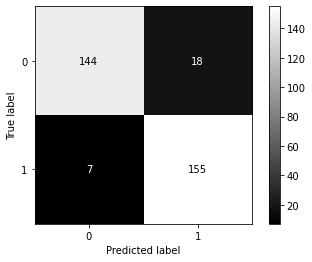

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


confusionMatrix = confusion_matrix(lab_test, predicts)

disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

disp.plot(cmap='gray')
